<h1>CNN Model</h1>

<h3>Process</h3>

<ol type='1'>
    <li>Data Loading and Understanding Data Structure</li>
    <li>Data Augmentation</li>
    <li>Data Preprocessing</li>
    <li>CNN Model Setup</li>
    <li>Training Phrase</li>
    <li>Optimising Phrase</li>
    <li>Testing Phrase</li>
</ol>

<h5>1. Data Loading and Understanding Data Structure <b>NumPy pipeline</b></h5>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

Exploration on stl10_binary

Summary:

- Our raw testing dataset and raw training dataset are in binary format (0s and 1s)

In [2]:
dataset_path = 'stl10_binary'
print("Files in dataset:")
for file in os.listdir(dataset_path):
    print(f"  - {file}")

Files in dataset:
  - fold_indices.txt
  - test_y.bin
  - test_X.bin
  - train_y.bin
  - train_X.bin
  - unlabeled_X.bin
  - class_names.txt


Check the labels

Summary:

- We have 10 classes (including, airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck)

In [3]:
with open('stl10_binary/class_names.txt', 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

print("Class names:")
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")

Class names:
  0: airplane
  1: bird
  2: car
  3: cat
  4: deer
  5: dog
  6: horse
  7: monkey
  8: ship
  9: truck


Read the binary file by using 'rb' (i.e. read binary)

    'r' - Read text
    'rb' - Read binary
    'w' - Write text (overwrites)
    'wb' - Write binary
    'a' - Append text

- Remember that our interval is from [0, 9] but the labels are in [1, 10].

In [4]:
with open('stl10_binary/train_y.bin', 'rb') as f:
    train_labels = np.fromfile(f, dtype=np.uint8)

print(f"Number of training labels: {len(train_labels)}")
print(f"Label data type: {train_labels.dtype}")
print(f"First 20 labels: {train_labels[:20]}")
print(f"Unique labels: {np.unique(train_labels)}")
print(f"Label range: [{train_labels.min()}, {train_labels.max()}]")

Number of training labels: 5000
Label data type: uint8
First 20 labels: [ 2  6  2  7  4 10  8  5  6  9  1  7  1  9  8  7  5  7  3  3]
Unique labels: [ 1  2  3  4  5  6  7  8  9 10]
Label range: [1, 10]


See training images and data structure

- Total Images = 5000
- Size of images are in 96 x 96 with 3 layers
- Data Type converted into uint8
- Pixel value range within [0, 255]

In [5]:
def read_all_data(path_to_data):
    with open(path_to_data, 'rb') as f:
        train_data = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(train_data, (-1, 3, 96, 96))
        images = np.transpose(images, (0, 3, 2, 1))
    return images

In [6]:
train_images = read_all_data('stl10_binary/train_X.bin')

print(f"Training images shape: {train_images.shape}")
print(f"Image data type: {train_images.dtype}")
print(f"Pixel value range: [{train_images.min()}, {train_images.max()}]")

Training images shape: (5000, 96, 96, 3)
Image data type: uint8
Pixel value range: [0, 255]


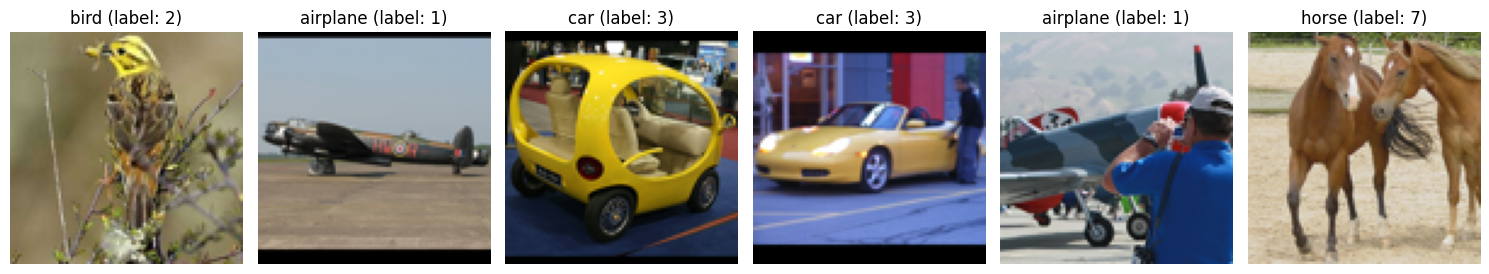

In [7]:
indices = [0, 10, 100, 1000, 2000, 3000]

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15, 3))

for i, idx in enumerate(indices):
    ax[i].imshow(train_images[idx])
    label = train_labels[idx]
    class_name = class_names[label - 1]  # Remember: labels are 1-indexed!
    ax[i].set_title(f"{class_name} (label: {label})")
    ax[i].axis('off')

plt.tight_layout()
plt.show()

- Correct data loading

Class distribution

- We have same class distribution

In [8]:
unique, counts = np.unique(train_labels, return_counts=True)

print("Training set class distribution:")
for label, count in zip(unique, counts):
    class_name = class_names[label - 1]
    print(f"  Label {label} ({class_name}): {count} samples")

print(f"\nTotal training samples: {counts.sum()}")

Training set class distribution:
  Label 1 (airplane): 500 samples
  Label 2 (bird): 500 samples
  Label 3 (car): 500 samples
  Label 4 (cat): 500 samples
  Label 5 (deer): 500 samples
  Label 6 (dog): 500 samples
  Label 7 (horse): 500 samples
  Label 8 (monkey): 500 samples
  Label 9 (ship): 500 samples
  Label 10 (truck): 500 samples

Total training samples: 5000


<h5>1. Data Loading and Understanding Data Structure in <b>TensorFlow Pipeline</b></h5>

In [9]:
import tensorflow as tf
import numpy as np
import random
import cv2

In [10]:
def load_stl10_tf(data_dir='stl10_binary'):

    def read_all_data(file_path):
        with open(file_path, 'rb') as f:
            train_data = np.fromfile(f, dtype=np.uint8)
            images = np.reshape(train_data, (-1, 3, 96, 96))
            images = np.transpose(images, (0, 3, 2, 1))
        return images
    
    def read_labels(filepath):
        with open(filepath, 'rb') as f:
            labels = np.fromfile(f, dtype=np.uint8)
        return labels - 1 

    train_data = read_all_data(f'{data_dir}/train_X.bin')
    train_label = read_labels(f'{data_dir}/train_y.bin')

    test_images = read_all_data(f'{data_dir}/test_X.bin')
    test_labels = read_labels(f'{data_dir}/test_y.bin')
    
    return train_data, train_label, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_stl10_tf()

print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Label range: [{train_labels.min()}, {train_labels.max()}]")


Training images shape: (5000, 96, 96, 3)
Training labels shape: (5000,)
Test images shape: (8000, 96, 96, 3)
Test labels shape: (8000,)
Label range: [0, 9]


In [11]:
train_labels_tf = train_labels - 1  # Convert from 1-10 to 0-9
test_labels_tf = test_labels - 1

<h5>2. Data Preprocessing</h5>

In [12]:
def preprocess_image(image):
    # Convert float [0,1] back to uint8 [0,255] for OpenCV
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    eq_img = cv2.equalizeHist(gray_img)
    blurred_img = cv2.GaussianBlur(eq_img, (7, 7), 1.0)
    
    processed_img = blurred_img.astype(np.float32) / 255.0
    processed_img = np.expand_dims(processed_img, axis=-1)  # (96, 96) → (96, 96, 1)
    
    return processed_img

# Test on one image
test_img = train_images[0]
processed = preprocess_image(test_img)
print(f"Original shape: {test_img.shape}")
print(f"Processed shape: {processed.shape}")
print(f"Value range: [{processed.min():.3f}, {processed.max():.3f}]")

Original shape: (96, 96, 3)
Processed shape: (96, 96, 1)
Value range: [0.031, 0.988]


In [13]:
print("Preprocessing training images...")
train_images_processed = np.array([preprocess_image(img) for img in train_images])

print("Preprocessing test images...")
test_images_processed = np.array([preprocess_image(img) for img in test_images])

print(f"\nProcessed training images shape: {train_images_processed.shape}")
print(f"Processed test images shape: {test_images_processed.shape}")
print(f"Training value range: [{train_images_processed.min():.3f}, {train_images_processed.max():.3f}]")
print(f"Test value range: [{test_images_processed.min():.3f}, {test_images_processed.max():.3f}]")

Preprocessing training images...
Preprocessing test images...

Processed training images shape: (5000, 96, 96, 1)
Processed test images shape: (8000, 96, 96, 1)
Training value range: [0.000, 1.000]
Test value range: [0.000, 1.000]


<h5>3. Data Augmentation</h5>

In [14]:
train_images_normalized = train_images_processed.astype('float32') / 255.0
test_images_normalized = test_images_processed.astype('float32') / 255.0

In [15]:
data_augmentation_1 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'), #Not one car, airplane are upside down by logical sense
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

data_augmentation_2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'), #Not one car, airplane are upside down by logical sense
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [16]:
def random_erasing(image, probability=1, sl=0.02, sh=0.4, r1=0.3):
    """
    Randomly erase rectangular regions from the image
    """
    if random.random() > probability:
        return image
    
    # Convert to numpy if it's a tensor
    if tf.is_tensor(image):
        image = image.numpy()
    
    # Make a copy to avoid modifying original
    image = image.copy()
    
    image_height, image_width, image_channel = image.shape
    area = image_height * image_width
    
    target_area = random.uniform(sl, sh) * area
    aspect_ratio = random.uniform(r1, 1/r1)
    
    # Use numpy's int conversion instead
    h = np.int32(np.sqrt(target_area * aspect_ratio))
    w = np.int32(np.sqrt(target_area / aspect_ratio))
    
    if w < image_width and h < image_height:
        x1 = random.randint(0, image_height - h)
        y1 = random.randint(0, image_width - w)
        
        # Erase the region with black (0)
        image[x1:x1+h, y1:y1+w, :] = 0
        
    return image

In [17]:
print("Generating augmented images...")
augmented_images = np.zeros_like(train_images_normalized)  # Preallocate with same shape
augmented_labels = np.zeros_like(train_labels)

for i, (img, label) in enumerate(zip(train_images_normalized, train_labels)):
    img_batch = tf.expand_dims(img, 0)
    aug_choice = random.randint(1, 2)
    
    if aug_choice == 1:
        aug_img = data_augmentation_1(img_batch, training=True)
        aug_img = tf.squeeze(aug_img, 0)  # Remove batch dimension FIRST
    else:
        aug_img = data_augmentation_2(img_batch, training=True)
        aug_img = tf.squeeze(aug_img, 0)  # Remove batch dimension FIRST
        aug_img = random_erasing(aug_img)  # Then apply erasing
    
    # Convert to numpy if needed
    if tf.is_tensor(aug_img):
        aug_img = aug_img.numpy()
    
    augmented_images[i] = aug_img
    augmented_labels[i] = label

Generating augmented images...


In [18]:
# Combine original + augmented
train_images_combined = np.concatenate([train_images_normalized, augmented_images], axis=0)
train_labels_combined = np.concatenate([train_labels, augmented_labels], axis=0)

print(f"\nOriginal training size: {len(train_images_normalized)}")
print(f"Augmented training size: {len(augmented_images)}")
print(f"Combined training size: {len(train_images_combined)}")
print(f"Combined images shape: {train_images_combined.shape}")
print(f"Combined labels shape: {train_labels_combined.shape}")


Original training size: 5000
Augmented training size: 5000
Combined training size: 10000
Combined images shape: (10000, 96, 96, 1)
Combined labels shape: (10000,)


In [19]:
BATCH_SIZE = 32

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_combined, train_labels_combined))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images_normalized, test_labels))

# Apply shuffling, batching, and prefetching to training set
train_dataset = (train_dataset
                 .shuffle(buffer_size=10000)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))

# Batch test set (no shuffling needed for evaluation)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("TensorFlow Data Pipeline Created!")
print(f"Training dataset: {train_dataset}")
print(f"Test dataset: {test_dataset}")

# Verify by checking one batch
for images, labels in train_dataset.take(1):
    print(f"\nBatch shape - Images: {images.shape}, Labels: {labels.shape}")
    print(f"Image value range: [{images.numpy().min():.3f}, {images.numpy().max():.3f}]")

TensorFlow Data Pipeline Created!
Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

Batch shape - Images: (32, 96, 96, 1), Labels: (32,)
Image value range: [0.000, 44.602]


2026-02-03 13:57:23.148188: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<h5>4. CNN Model Setup</h5>

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1), padding='same'),
    AveragePooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    AveragePooling2D((3, 3)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    AveragePooling2D((3, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.summary()

/Users/tatxiantey/Desktop/cnn_assignment_2/ConvNet_STL/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 48, 48, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 16, 16, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 5, 5, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,690 (1.92 MB)

 Trainable params: 503,690 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

<h5>5. Training Phrase</h5>

Oberservation:

- Using Learning rate 0.01 is cooked, so use 0.001

In [23]:
train_size = 0.8
train_dataset = train_dataset.take(int(len(train_dataset) * train_size))
val_dataset = train_dataset.skip(int(len(train_dataset) * train_size))

In [24]:
early_stopping = EarlyStopping(patience=5, monitor='val_accuracy', mode='max', restore_best_weights=True)
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    verbose=-1,
                    callbacks=[early_stopping]
                    )

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


<h5>6. Testing Phrase</h5>

In [25]:
import matplotlib.pyplot as plt

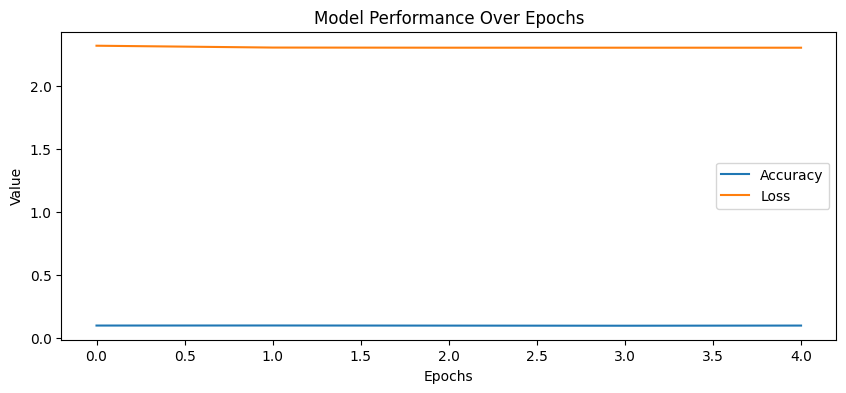

In [26]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.title('Model Performance Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [27]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.1000 - loss: 2.3027
✅ Test Accuracy: 10.00%


In [26]:
import seaborn as sns

In [27]:
from sklearn.metrics import classification_report
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

2026-02-03 13:27:49.520982: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step


NameError: name 'class_names' is not defined

<Figure size 600x500 with 0 Axes>